Author: Yann Charbon <yann.charbon@heig-vd.ch>

In [1]:
from DAGDatasetGenerator import DAGDatasetGenerator
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from scipy.stats import entropy

generator = DAGDatasetGenerator()

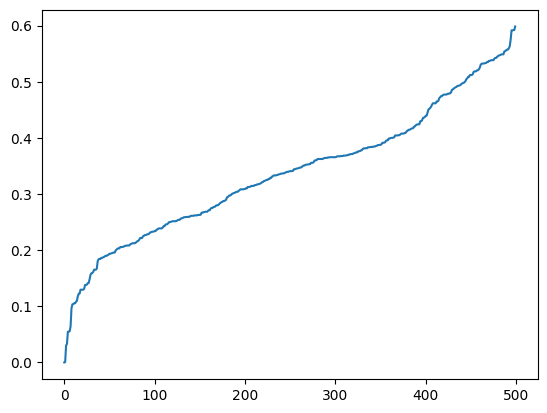

In [19]:
dags, perfs, adj_matrix = generator.run_once_double_flux(22, keep_dags_count=500, keep_random_dags=True, max_steps=2500)

perfs = np.asarray(perfs)
perfs = 1 - perfs / np.max(perfs)
dags = np.asarray(dags)
sorted_indices = np.argsort(perfs)
perfs_sorted = perfs[sorted_indices]
dags_sorted = dags[sorted_indices]

fig = plt.figure()
plt.plot(perfs_sorted)
plt.show()

In [24]:
def compute_empirical_perf(G: nx.DiGraph, adj_matrix):
    def get_nodes_at_rank(G: nx.DiGraph, rank: int):
        # Compute shortest path lengths from the source
        path_lengths = nx.single_source_shortest_path_length(G, 0)
        return [node for node, length in path_lengths.items() if length == rank]

    def get_max_rank(G: nx.DiGraph):
        path_lengths = nx.single_source_shortest_path_length(G, 0)
        return max(path_lengths.values())

    def compute_weighted_branching_factor(G: nx.DiGraph):
        score = 0
        rank = 0
        nodes_at_rank = get_nodes_at_rank(G, rank)
        while nodes_at_rank:
            for node in nodes_at_rank:
                children_count = len(list(G.successors(node)))
                if children_count > 1:
                    score += children_count
            rank += 1
            nodes_at_rank = get_nodes_at_rank(G, rank)
        return score

    def compute_global_branching_performance(G: nx.DiGraph, adj_matrix):
        global_branching_perf = 0
        for node in range(len(G.nodes)):
            branching_perf = 1
            children = list(G.successors(node))
            if not children:
                continue
            for child in children:
                branching_perf *= adj_matrix[node][child]
            if node > 0:
                parent = list(G.predecessors(node))[0]
                branching_perf *= adj_matrix[parent][node]
            global_branching_perf += branching_perf
        return global_branching_perf

    def compute_perf_for_one_node(node, G: nx.DiGraph, adj_matrix):
        rank = nx.shortest_path_length(G, target=node, source=0)
        done = False
        parent = 0
        child = node
        link_to_root_quality = 1.0
        cumulated_link_to_root_children_count = 0
        while not done:
            parent = list(G.predecessors(child))[0]
            if parent == 0:
                done = True
                break
            link_to_root_quality *= adj_matrix[parent][child]
            cumulated_link_to_root_children_count += len(list(G.successors(child)))
            child = parent
        children_count = len(list(G.successors(node)))
        return cumulated_link_to_root_children_count, children_count, rank, link_to_root_quality

    def compute_tree_balance(G: nx.DiGraph):
        def count_descendants(node):
            return len(nx.descendants(G, node))

        balance_factors = []
        max_desc = 0

        for node in G.nodes:
            children = list(G.successors(node))
            if len(children) < 2:
                continue
            child_desc_counts = [count_descendants(child) for child in children]
            balance = max(child_desc_counts) - min(child_desc_counts)
            balance_factors.append(balance)
            max_desc = max(max_desc, sum(child_desc_counts))

        if not balance_factors or max_desc == 0:
            return 0.0

        return np.mean(balance_factors) / max_desc


    def compute_average_subtree_depth(G: nx.DiGraph):
        n = len(G.nodes)
        if n <= 1:
            return 0.0

        depths = []
        for node in G.nodes:
            lengths = nx.single_source_shortest_path_length(G, node)
            sub_depths = [v for k, v in lengths.items() if k != node]
            if sub_depths:
                depths.append(np.mean(sub_depths))
        if not depths:
            return 0.0

        return np.mean(depths) / (n - 1)

    def compute_outdegree_variance(G: nx.DiGraph):
        out_degrees = [G.out_degree(n) for n in G.nodes if G.out_degree(n) > 0]
        return np.var(out_degrees)

    def compute_density(G: nx.DiGraph):
        n = len(G.nodes)
        m = len(G.edges)
        return m / (n * (n - 1)) if n > 1 else 0

    def compute_leaf_count(G: nx.DiGraph):
        n = len(G.nodes)
        if n == 0:
            return 0.0
        leaf_count = len([node for node in G.nodes if G.out_degree(node) == 0])
        return leaf_count / n

    def compute_root_to_leaf_depth_variance(G: nx.DiGraph):
        leaves = [n for n in G.nodes if G.out_degree(n) == 0]
        if not leaves:
            return 0.0
        path_lengths = []
        for leaf in leaves:
            try:
                path_length = nx.shortest_path_length(G, source=0, target=leaf)
                path_lengths.append(path_length)
            except nx.NetworkXNoPath:
                continue
        if not path_lengths:
            return 0.0
        return np.std(path_lengths) / (np.mean(path_lengths) + 1e-6)  # Coefficient of variation

    def compute_max_fanout(G: nx.DiGraph):
        return max([G.out_degree(n) for n in G.nodes], default=0) / len(G.nodes)

    def compute_average_ancestor_count(G: nx.DiGraph):
        n = len(G.nodes)
        if n <= 1:
            return 0.0
        ancestor_counts = [len(nx.ancestors(G, n)) for n in G.nodes]
        return np.mean(ancestor_counts) / (n - 1)

    def compute_subtree_size_entropy(G: nx.DiGraph):
        def count_descendants(node):
            return len(nx.descendants(G, node))

        root_children = list(G.successors(0))
        if not root_children:
            return 0.0

        sizes = [count_descendants(child) for child in root_children]
        total = sum(sizes)
        if total == 0:
            return 0.0

        probs = [s / total for s in sizes]
        return entropy(probs) / (1 if np.isnan(np.log(len(probs))) or np.log(len(probs)) == 0 else np.log(len(probs)))  # Normalised entropy [0,1]

    def compute_depth_width_ratio(G: nx.DiGraph):
        if len(G.nodes) <= 1:
            return 0.0

        # Depth: max shortest path from root to any reachable node
        try:
            depths = [
                nx.shortest_path_length(G, source=0, target=n)
                for n in G.nodes
                if nx.has_path(G, 0, n)
            ]
        except nx.NetworkXNoPath:
            return 0.0

        if not depths:
            return 0.0

        max_depth = max(depths)

        # Width: max number of nodes at the same depth
        level_counts = {}
        for d in depths:
            level_counts[d] = level_counts.get(d, 0) + 1
        max_width = max(level_counts.values())

        return max_depth / (max_depth + max_width + 1e-6)  # In (0, 1)

    def compute_outdegree_gini(G: nx.DiGraph):
        out_degs = np.array([G.out_degree(n) for n in G.nodes])
        sorted_degs = np.sort(out_degs)
        n = len(sorted_degs)
        if n == 0 or sorted_degs[-1] == 0:
            return 0.0
        # Gini calculation
        cumulative = np.cumsum(sorted_degs) / np.sum(sorted_degs)
        gini = 1 - 2 * np.trapz(cumulative, dx=1/n)
        return gini

    def compute_longest_path(G: nx.DiGraph):
        return nx.algorithms.dag.dag_longest_path_length(G) / len(G.edges)

    def compute_strong_edge_fraction(G: nx.DiGraph, adj_matrix, threshold=0.9):
        if G.number_of_edges() == 0:
            return 0.0
        # Extract edges as arrays
        edges = np.array(G.edges)
        u = edges[:, 0]
        v = edges[:, 1]

        edge_weights = adj_matrix[u, v]
        strong_edges = np.sum(edge_weights >= threshold)
        return strong_edges / G.number_of_edges()

    def compute_weak_edge_fraction(G: nx.DiGraph, adj_matrix, threshold=0.1):
        if G.number_of_edges() == 0:
            return 0.0
        # Extract edges as arrays
        edges = np.array(G.edges)
        u = edges[:, 0]
        v = edges[:, 1]

        edge_weights = adj_matrix[u, v]
        weak_edges = np.sum(edge_weights < threshold)
        return weak_edges / G.number_of_edges()

    def compute_extreme_path_fraction(G: nx.DiGraph):
        leaves = [n for n in G.nodes if G.out_degree(n) == 0]
        if not leaves:
            return 0.0

        path_lengths = []
        for leaf in leaves:
            if nx.has_path(G, 0, leaf):
                path_lengths.append(nx.shortest_path_length(G, 0, leaf))

        if not path_lengths:
            return 0.0

        max_possible = len(G.nodes) - 1
        short_threshold = 1
        long_threshold = max_possible * 0.75  # 75% of max depth

        short_paths = sum(1 for l in path_lengths if l <= short_threshold)
        long_paths = sum(1 for l in path_lengths if l >= long_threshold)

        return (short_paths + long_paths) / len(path_lengths)

    def compute_bottleneck_factor(G: nx.DiGraph):
        n = G.number_of_nodes()
        if n == 0:
            return 0.0

        in_degs = [G.in_degree(n) for n in G.nodes]
        out_degs = [G.out_degree(n) for n in G.nodes]

        in_thresh = np.percentile(in_degs, 75)
        out_thresh = np.percentile(out_degs, 75)

        bottlenecks = [node for node in G.nodes
                    if G.in_degree(node) >= in_thresh and G.out_degree(node) >= out_thresh]

        return len(bottlenecks) / n

    def compute_betweenness_centrality_skew(G: nx.DiGraph):
        if G.number_of_nodes() <= 2:
            return 0.0
        centrality = nx.betweenness_centrality(G, normalized=True)
        values = np.array(list(centrality.values()))
        if np.mean(values) == 0:
            return 0.0
        return np.std(values) / (np.mean(values) + 1e-6)

    def compute_tree_height_balance(G: nx.DiGraph):
        leaves = [n for n in G.nodes if G.out_degree(n) == 0]
        if not leaves:
            return 0.0
        path_lengths = []
        for leaf in leaves:
            if nx.has_path(G, 0, leaf):
                path_lengths.append(nx.shortest_path_length(G, 0, leaf))
        if not path_lengths:
            return 0.0
        max_len = max(path_lengths)
        min_len = min(path_lengths)
        return 1 - (min_len / (max_len + 1e-6))  # 0 if perfectly balanced, →1 if very unbalanced

    def compute_path_redundancy(G: nx.DiGraph):
        leaves = [n for n in G.nodes if G.out_degree(n) == 0]
        total = 0
        count = 0
        for leaf in leaves:
            paths = list(nx.all_simple_paths(G, source=0, target=leaf))
            if paths:
                total += len(paths)
                count += 1
        if count == 0:
            return 0.0
        return min(total / count, 10) / 10  # Cap at 10, normalised

    def compute_average_clustering_coefficient(G: nx.DiGraph):
        undirected = G.to_undirected()
        return nx.average_clustering(undirected)  # Already normalised [0, 1]

    def compute_edge_weight_variance(G: nx.DiGraph, adj_matrix):
        weights = [adj_matrix[u][v] for u, v in G.edges]
        if not weights:
            return 0.0
        return np.var(weights)

    def compute_root_fanin_ratio(G: nx.DiGraph):
        non_root_nodes = [n for n in G.nodes if n != 0]
        if not non_root_nodes:
            return 0.0
        max_fanin = max([G.in_degree(n) for n in non_root_nodes], default=0)
        return max_fanin / len(G.nodes)

    def compute_transitive_reduction_ratio(G: nx.DiGraph):
        try:
            tr = nx.transitive_reduction(G)
            return 1 - (tr.number_of_edges() / G.number_of_edges() + 1e-6)
        except:
            return 0.0



    total_nodes_count = len(G.nodes)

    path_sum_list = []
    global_children_count = 0
    global_rank = 0
    global_link_to_root_quality = 0

    for node in range(1, len(G.nodes)):
        cumulated_link_to_root_children_count, children_count, rank, link_to_root_quality = compute_perf_for_one_node(node, G, adj_matrix)
        path_sum_list.append(cumulated_link_to_root_children_count)
        global_children_count += children_count
        global_rank += rank
        global_link_to_root_quality += link_to_root_quality

    # Normalize
    global_children_count_ratio = global_children_count / total_nodes_count

    # Ensure cumulated link-to-root children count ratio stays in [0,1]
    if len(path_sum_list) == 0:
        global_cumulated_link_to_root_children_count_ratio = 0
    else:
        max_path_sum = max(path_sum_list)
        if max_path_sum == 0:
            global_cumulated_link_to_root_children_count_ratio = 0
        else:
            total_path_sum = sum(path_sum_list)
            global_cumulated_link_to_root_children_count_ratio = total_path_sum / (len(path_sum_list) * max_path_sum)

    max_rank = get_max_rank(G)
    max_possible_rank_sum = total_nodes_count * max_rank
    global_rank_ratio = global_rank / max_possible_rank_sum if max_possible_rank_sum > 0 else 0
    global_link_to_root_quality_ratio = global_link_to_root_quality / total_nodes_count

    global_branching_factor_ratio = compute_weighted_branching_factor(G) / total_nodes_count
    global_max_rank_ratio = get_max_rank(G) / total_nodes_count
    global_branching_perf_ratio = compute_global_branching_performance(G, adj_matrix) / total_nodes_count
    global_tree_balance_ratio = compute_tree_balance(G)
    global_avg_subtree_depth_ratio = compute_average_subtree_depth(G)
    global_outdegree_variance_ratio = compute_outdegree_variance(G)
    global_density = compute_density(G)
    global_leaf_count = compute_leaf_count(G)
    global_root_to_leaf_depth_variance = compute_root_to_leaf_depth_variance(G)
    global_max_fanout = compute_max_fanout(G)
    global_average_ancestor_count = compute_average_ancestor_count(G)
    global_subtree_size_entropy = compute_subtree_size_entropy(G)
    global_depth_width_ratio = compute_depth_width_ratio(G)
    global_outdegree_gini = compute_outdegree_gini(G)
    global_longest_path = compute_longest_path(G)
    global_strong_edge_fraction = compute_strong_edge_fraction(G, adj_matrix, 0.94)
    global_weak_edge_fraction = compute_weak_edge_fraction(G, adj_matrix, 0.9)
    global_extreme_path_fraction = compute_extreme_path_fraction(G)
    global_bottleneck_factor = compute_bottleneck_factor(G)
    global_betweenness_centrality_skew = compute_betweenness_centrality_skew(G)
    global_tree_height_balance = compute_tree_height_balance(G)
    global_path_redundancy = compute_path_redundancy(G)
    global_average_clustering_coefficient = compute_average_clustering_coefficient(G)
    global_edge_weight_variance = compute_edge_weight_variance(G, adj_matrix)
    global_root_fanin_ratio = compute_root_fanin_ratio(G)
    global_transitive_reduction_ratio = compute_transitive_reduction_ratio(G)

    return (
        global_children_count_ratio,
        global_cumulated_link_to_root_children_count_ratio,
        global_rank_ratio,
        global_link_to_root_quality_ratio,
        global_branching_factor_ratio,
        global_max_rank_ratio,
        global_branching_perf_ratio,
        global_tree_balance_ratio,
        global_avg_subtree_depth_ratio,
        global_outdegree_variance_ratio,
        global_density,
        global_leaf_count,
        global_root_to_leaf_depth_variance,
        global_max_fanout,
        global_average_ancestor_count,
        global_subtree_size_entropy,
        global_depth_width_ratio,
        global_outdegree_gini,
        global_longest_path,
        global_strong_edge_fraction,
        global_weak_edge_fraction,
        global_extreme_path_fraction,
        global_bottleneck_factor,
        global_betweenness_centrality_skew,
        global_tree_height_balance,
        global_path_redundancy,
        global_average_clustering_coefficient,
        global_edge_weight_variance,
        global_root_fanin_ratio,
        global_transitive_reduction_ratio
    )

/tmp/ipykernel_6121/982429319.py:187: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(cumulative, dx=1/n)


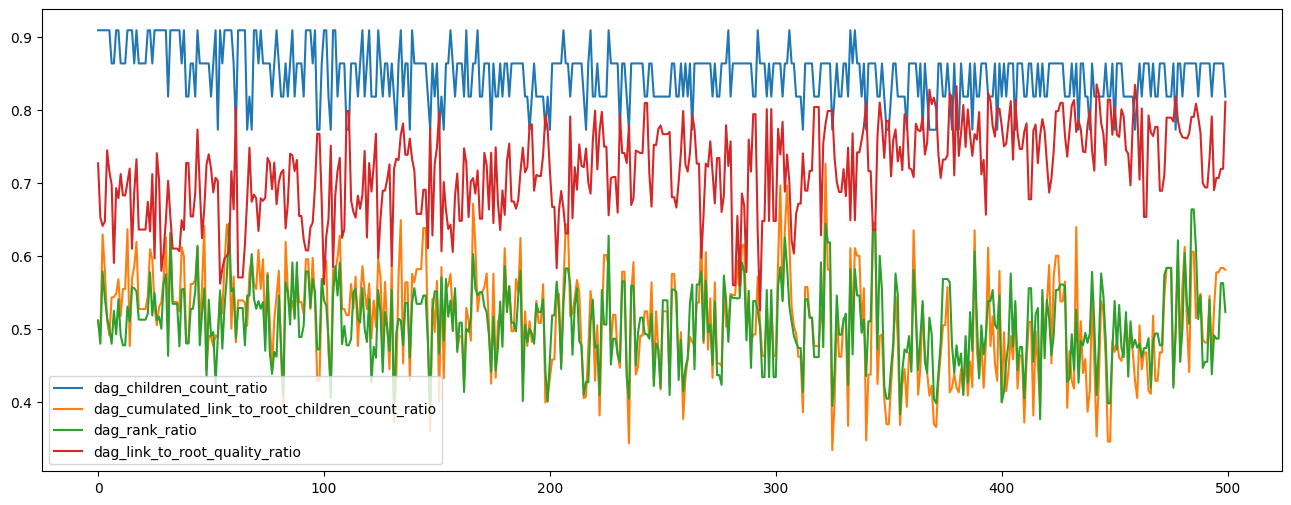

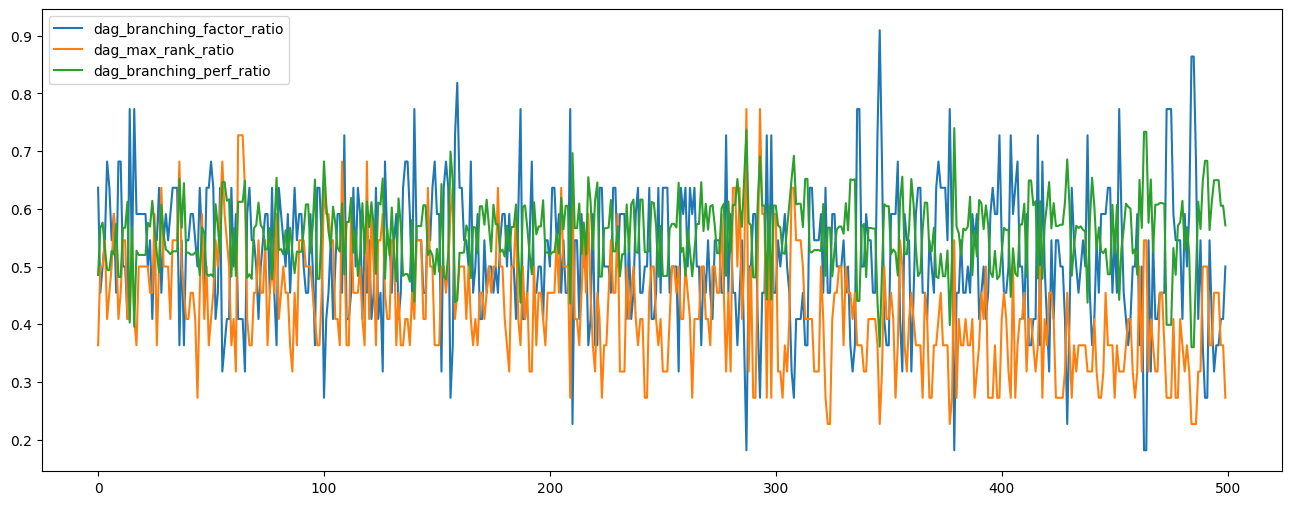

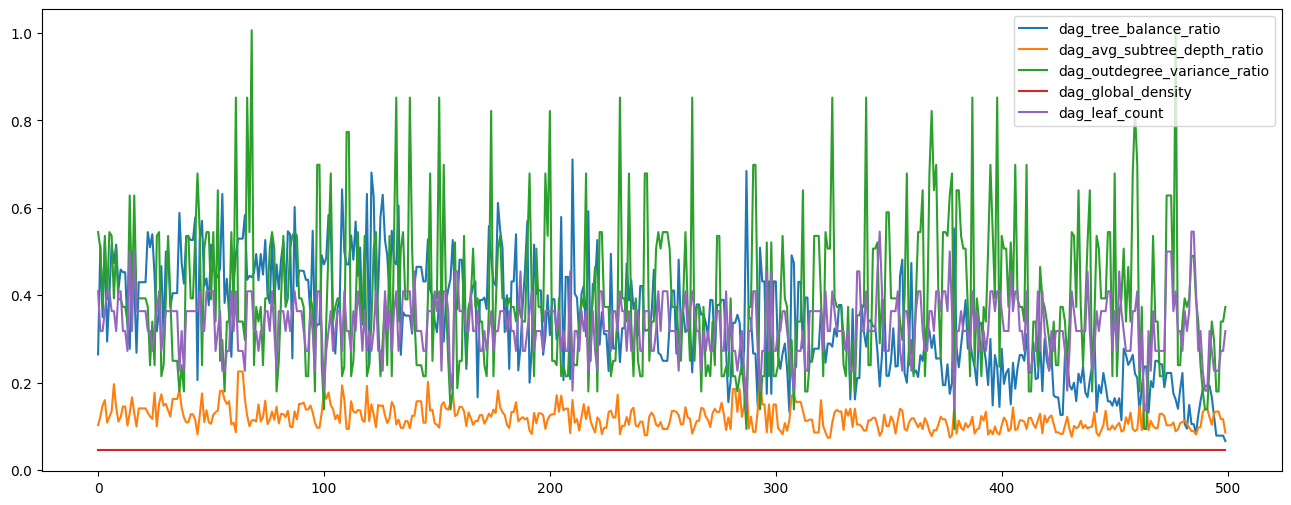

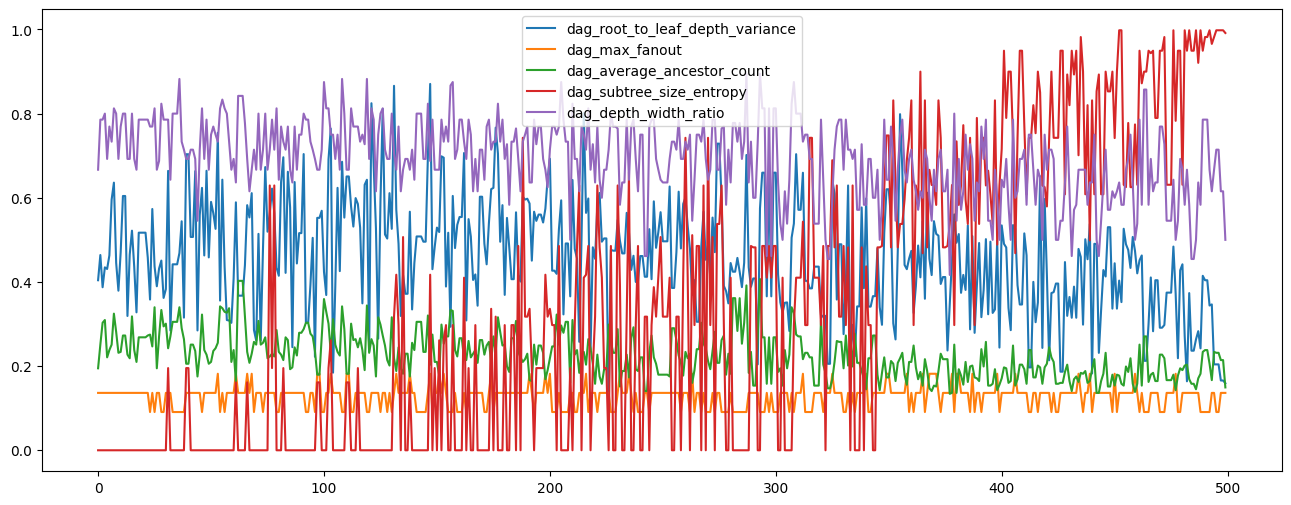

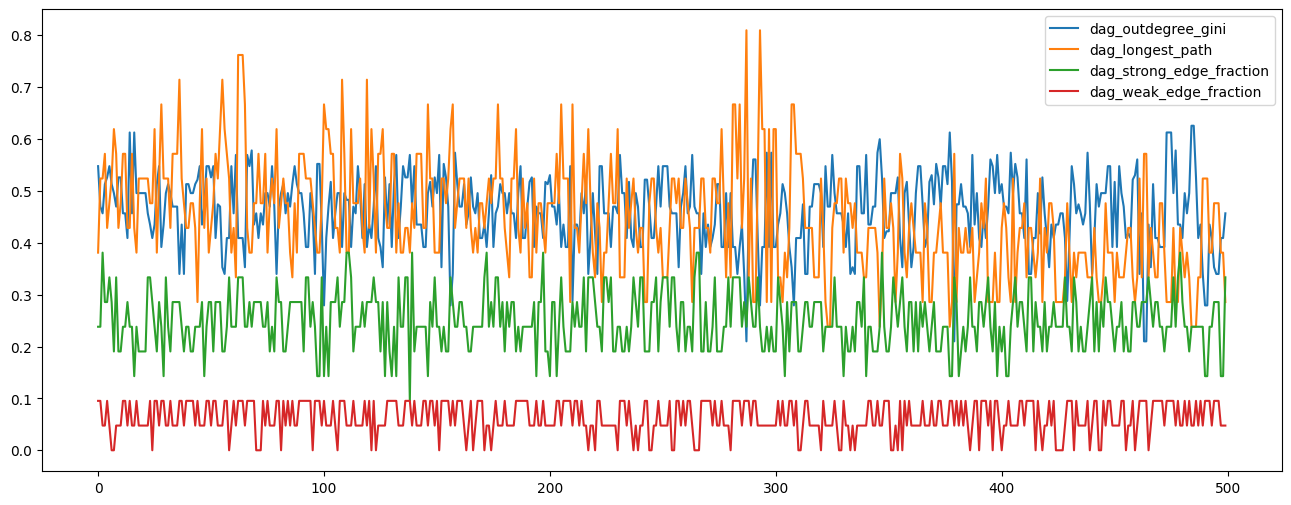

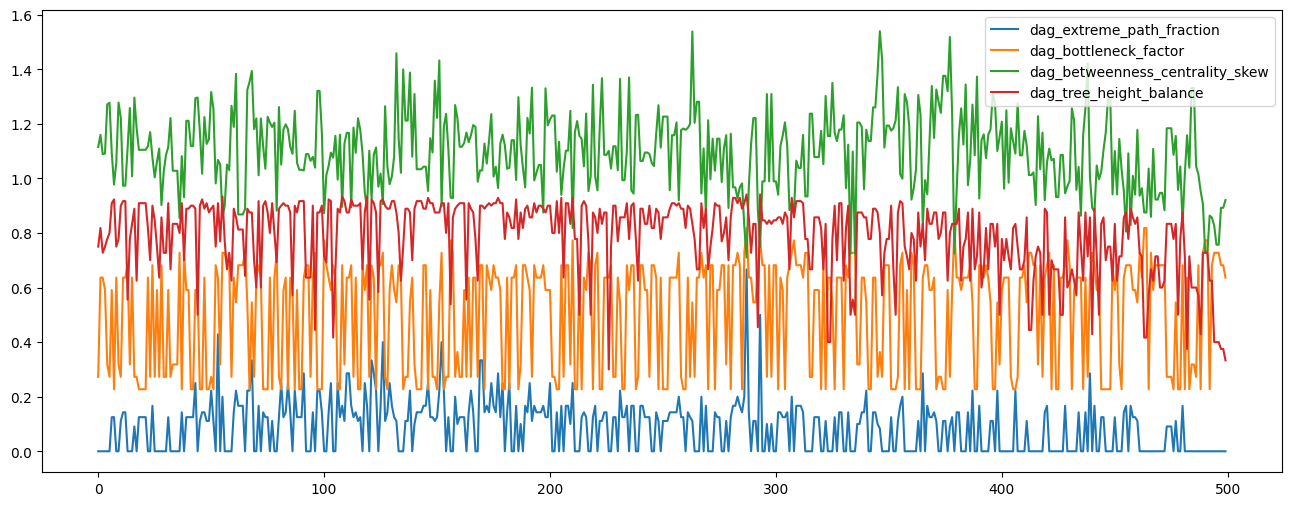

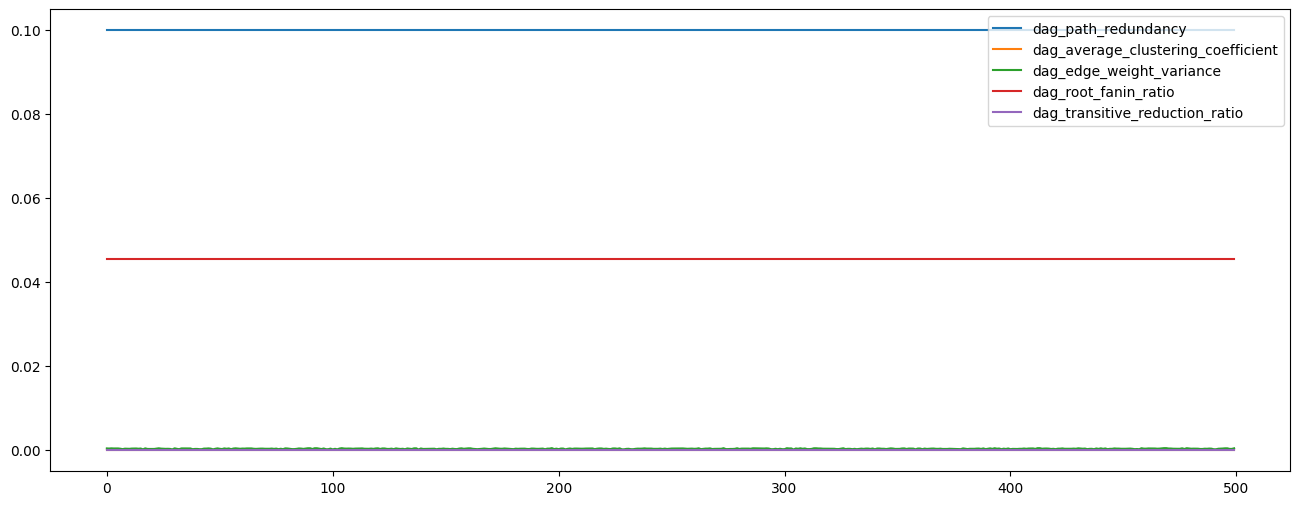

In [25]:
dag_children_count_ratio = []
dag_cumulated_link_to_root_children_count_ratio = []
dag_rank_ratio = []
dag_link_to_root_quality_ratio = []
dag_branching_factor_ratio = []
dag_max_rank_ratio = []
dag_branching_perf_ratio = []
dag_tree_balance_ratio = []
dag_avg_subtree_depth_ratio = []
dag_outdegree_variance_ratio = []
dag_density = []
dag_leaf_count = []
dag_root_to_leaf_depth_variance = []
dag_max_fanout = []
dag_average_ancestor_count = []
dag_subtree_size_entropy = []
dag_depth_width_ratio = []
dag_outdegree_gini = []
dag_longest_path = []
dag_strong_edge_fraction = []
dag_weak_edge_fraction = []
dag_extreme_path_fraction = []
dag_bottleneck_factor = []
dag_betweenness_centrality_skew = []
dag_tree_height_balance = []
dag_path_redundancy = []
dag_average_clustering_coefficient = []
dag_edge_weight_variance = []
dag_root_fanin_ratio = []
dag_transitive_reduction_ratio = []


for dag in dags:
    G = nx.DiGraph()
    G.add_edges_from(dag)

    (
        children_count_ratio,
        cumulated_link_to_root_children_count_ratio,
        rank_ratio,
        link_to_root_quality_ratio,
        branching_factor_ratio,
        max_rank_ratio,
        branching_perf_ratio,
        tree_balance_ratio,
        avg_subtree_depth_ratio,
        outdegree_variance_ratio,
        density,
        leaf_count,
        root_to_leaf_depth_variance,
        max_fanout,
        average_ancestor_count,
        subtree_size_entropy,
        depth_width_ratio,
        outdegree_gini,
        longest_path,
        strong_edge_fraction,
        weak_edge_fraction,
        extreme_path_fraction,
        bottleneck_factor,
        betweenness_centrality_skew,
        tree_height_balance,
        path_redundancy,
        average_clustering_coefficient,
        edge_weight_variance,
        root_fanin_ratio,
        transitive_reduction_ratio
    ) = compute_empirical_perf(G, adj_matrix)

    # Append to lists
    dag_children_count_ratio.append(children_count_ratio)
    dag_cumulated_link_to_root_children_count_ratio.append(cumulated_link_to_root_children_count_ratio)
    dag_rank_ratio.append(rank_ratio)
    dag_link_to_root_quality_ratio.append(link_to_root_quality_ratio)
    dag_branching_factor_ratio.append(branching_factor_ratio)
    dag_max_rank_ratio.append(max_rank_ratio)
    dag_branching_perf_ratio.append(branching_perf_ratio)
    dag_tree_balance_ratio.append(tree_balance_ratio)
    dag_avg_subtree_depth_ratio.append(avg_subtree_depth_ratio)
    dag_outdegree_variance_ratio.append(outdegree_variance_ratio)
    dag_density.append(density)
    dag_leaf_count.append(leaf_count)
    dag_root_to_leaf_depth_variance.append(root_to_leaf_depth_variance)
    dag_max_fanout.append(max_fanout)
    dag_average_ancestor_count.append(average_ancestor_count)
    dag_subtree_size_entropy.append(subtree_size_entropy)
    dag_depth_width_ratio.append(depth_width_ratio)
    dag_outdegree_gini.append(outdegree_gini)
    dag_longest_path.append(longest_path)
    dag_strong_edge_fraction.append(strong_edge_fraction)
    dag_weak_edge_fraction.append(weak_edge_fraction)
    dag_extreme_path_fraction.append(extreme_path_fraction)
    dag_bottleneck_factor.append(bottleneck_factor)
    dag_betweenness_centrality_skew.append(betweenness_centrality_skew)
    dag_tree_height_balance.append(tree_height_balance)
    dag_path_redundancy.append(path_redundancy)
    dag_average_clustering_coefficient.append(average_clustering_coefficient)
    dag_edge_weight_variance.append(edge_weight_variance)
    dag_root_fanin_ratio.append(root_fanin_ratio)
    dag_transitive_reduction_ratio.append(transitive_reduction_ratio)

# Convert lists to NumPy arrays
dag_children_count_ratio = np.array(dag_children_count_ratio)
dag_cumulated_link_to_root_children_count_ratio = np.array(dag_cumulated_link_to_root_children_count_ratio)
dag_rank_ratio = np.array(dag_rank_ratio)
dag_link_to_root_quality_ratio = np.array(dag_link_to_root_quality_ratio)
dag_branching_factor_ratio = np.array(dag_branching_factor_ratio)
dag_max_rank_ratio = np.array(dag_max_rank_ratio)
dag_branching_perf_ratio = np.array(dag_branching_perf_ratio)
dag_tree_balance_ratio = np.array(dag_tree_balance_ratio)
dag_avg_subtree_depth_ratio = np.array(dag_avg_subtree_depth_ratio)
dag_outdegree_variance_ratio = np.array(dag_outdegree_variance_ratio)
dag_global_density = np.array(dag_density)
dag_leaf_count = np.array(dag_leaf_count)
dag_root_to_leaf_depth_variance = np.array(dag_root_to_leaf_depth_variance)
dag_max_fanout = np.array(dag_max_fanout)
dag_average_ancestor_count = np.array(dag_average_ancestor_count)
dag_subtree_size_entropy = np.array(dag_subtree_size_entropy)
dag_depth_width_ratio = np.array(dag_depth_width_ratio)
dag_outdegree_gini = np.array(dag_outdegree_gini)
dag_longest_path = np.array(dag_longest_path)
dag_strong_edge_fraction = np.array(dag_strong_edge_fraction)
dag_weak_edge_fraction = np.array(dag_weak_edge_fraction)
dag_extreme_path_fraction = np.array(dag_extreme_path_fraction)
dag_bottleneck_factor = np.array(dag_bottleneck_factor)
dag_betweenness_centrality_skew = np.array(dag_betweenness_centrality_skew)
dag_tree_height_balance = np.array(dag_tree_height_balance)
dag_path_redundancy = np.array(dag_path_redundancy)
dag_average_clustering_coefficient = np.array(dag_average_clustering_coefficient)
dag_edge_weight_variance = np.array(dag_edge_weight_variance)
dag_root_fanin_ratio = np.array(dag_root_fanin_ratio)
dag_transitive_reduction_ratio = np.array(dag_transitive_reduction_ratio)


# Apply sorted indices
dag_children_count_ratio = dag_children_count_ratio[sorted_indices]
dag_cumulated_link_to_root_children_count_ratio = dag_cumulated_link_to_root_children_count_ratio[sorted_indices]
dag_rank_ratio = dag_rank_ratio[sorted_indices]
dag_link_to_root_quality_ratio = dag_link_to_root_quality_ratio[sorted_indices]
dag_branching_factor_ratio = dag_branching_factor_ratio[sorted_indices]
dag_max_rank_ratio = dag_max_rank_ratio[sorted_indices]
dag_branching_perf_ratio = dag_branching_perf_ratio[sorted_indices]
dag_tree_balance_ratio = dag_tree_balance_ratio[sorted_indices]
dag_avg_subtree_depth_ratio = dag_avg_subtree_depth_ratio[sorted_indices]
dag_outdegree_variance_ratio = dag_outdegree_variance_ratio[sorted_indices]
dag_global_density = dag_global_density[sorted_indices]
dag_leaf_count = dag_leaf_count[sorted_indices]
dag_root_to_leaf_depth_variance = dag_root_to_leaf_depth_variance[sorted_indices]
dag_max_fanout = dag_max_fanout[sorted_indices]
dag_average_ancestor_count = dag_average_ancestor_count[sorted_indices]
dag_subtree_size_entropy = dag_subtree_size_entropy[sorted_indices]
dag_depth_width_ratio = dag_depth_width_ratio[sorted_indices]
dag_outdegree_gini = dag_outdegree_gini[sorted_indices]
dag_longest_path = dag_longest_path[sorted_indices]
dag_strong_edge_fraction = dag_strong_edge_fraction[sorted_indices]
dag_weak_edge_fraction = dag_weak_edge_fraction[sorted_indices]
dag_extreme_path_fraction = dag_extreme_path_fraction[sorted_indices]
dag_bottleneck_factor = dag_bottleneck_factor[sorted_indices]
dag_betweenness_centrality_skew = dag_betweenness_centrality_skew[sorted_indices]
dag_tree_height_balance = dag_tree_height_balance[sorted_indices]
dag_path_redundancy = dag_path_redundancy[sorted_indices]
dag_average_clustering_coefficient = dag_average_clustering_coefficient[sorted_indices]
dag_edge_weight_variance = dag_edge_weight_variance[sorted_indices]
dag_root_fanin_ratio = dag_root_fanin_ratio[sorted_indices]
dag_transitive_reduction_ratio = dag_transitive_reduction_ratio[sorted_indices]


plt.figure(figsize=(16, 6))
plt.plot(dag_children_count_ratio, label="dag_children_count_ratio")
plt.plot(dag_cumulated_link_to_root_children_count_ratio, label="dag_cumulated_link_to_root_children_count_ratio")
plt.plot(dag_rank_ratio, label="dag_rank_ratio")
plt.plot(dag_link_to_root_quality_ratio, label="dag_link_to_root_quality_ratio")
plt.legend()
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(dag_branching_factor_ratio, label="dag_branching_factor_ratio")
plt.plot(dag_max_rank_ratio, label="dag_max_rank_ratio")
plt.plot(dag_branching_perf_ratio, label="dag_branching_perf_ratio")
plt.legend()
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(dag_tree_balance_ratio, label="dag_tree_balance_ratio")
plt.plot(dag_avg_subtree_depth_ratio, label="dag_avg_subtree_depth_ratio")
plt.plot(dag_outdegree_variance_ratio, label="dag_outdegree_variance_ratio")
plt.plot(dag_global_density, label="dag_global_density")
plt.plot(dag_leaf_count, label="dag_leaf_count")
plt.legend()
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(dag_root_to_leaf_depth_variance, label="dag_root_to_leaf_depth_variance")
plt.plot(dag_max_fanout, label="dag_max_fanout")
plt.plot(dag_average_ancestor_count, label="dag_average_ancestor_count")
plt.plot(dag_subtree_size_entropy, label="dag_subtree_size_entropy")
plt.plot(dag_depth_width_ratio, label="dag_depth_width_ratio")
plt.legend()
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(dag_outdegree_gini, label="dag_outdegree_gini")
plt.plot(dag_longest_path, label="dag_longest_path")
plt.plot(dag_strong_edge_fraction, label="dag_strong_edge_fraction")
plt.plot(dag_weak_edge_fraction, label="dag_weak_edge_fraction")
plt.legend()
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(dag_extreme_path_fraction, label="dag_extreme_path_fraction")
plt.plot(dag_bottleneck_factor, label="dag_bottleneck_factor")
plt.plot(dag_betweenness_centrality_skew, label="dag_betweenness_centrality_skew")
plt.plot(dag_tree_height_balance, label="dag_tree_height_balance")
plt.legend()
plt.show()

plt.figure(figsize=(16, 6))
plt.plot(dag_path_redundancy, label="dag_path_redundancy")
plt.plot(dag_average_clustering_coefficient, label="dag_average_clustering_coefficient")
plt.plot(dag_edge_weight_variance, label="dag_edge_weight_variance")
plt.plot(dag_root_fanin_ratio, label="dag_root_fanin_ratio")
plt.plot(dag_transitive_reduction_ratio, label="dag_transitive_reduction_ratio")
plt.legend()
plt.show()

In [2]:
# construct dataset

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import optuna
import joblib

Generated for topology 0


/tmp/ipykernel_6121/982429319.py:187: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(cumulative, dx=1/n)


Generated for topology 1
Generated for topology 2
Generated for topology 3
Generated for topology 4
Generated for topology 5
Generated for topology 6
Generated for topology 7
Generated for topology 8
Generated for topology 9
Generated for topology 10
Generated for topology 11
Generated for topology 12
Generated for topology 13
Generated for topology 14
Generated for topology 15
Generated for topology 16
Generated for topology 17
Generated for topology 18
Generated for topology 19
Generated for topology 20
Generated for topology 21
Generated for topology 22
Generated for topology 23
Generated for topology 24
Generated for topology 25
Generated for topology 26
Generated for topology 27
Generated for topology 28
Generated for topology 29
Generated for topology 30
Generated for topology 31
Generated for topology 32
Generated for topology 33
Generated for topology 34
Generated for topology 35
Generated for topology 36
Generated for topology 37
Generated for topology 38
Generated for topolog

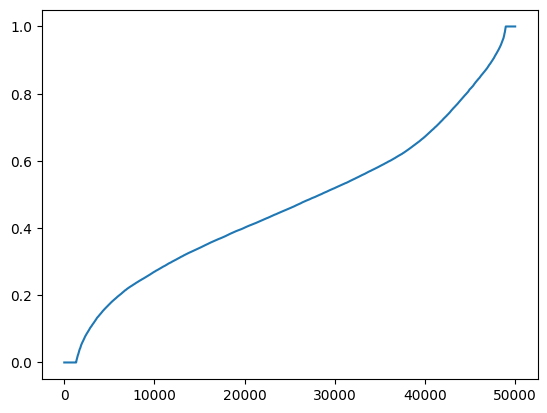

In [26]:
dag_children_count_ratio = []
dag_cumulated_link_to_root_children_count_ratio = []
dag_rank_ratio = []
dag_link_to_root_quality_ratio = []
dag_branching_factor_ratio = []
dag_max_rank_ratio = []
dag_branching_perf_ratio = []
dag_tree_balance_ratio = []
dag_avg_subtree_depth_ratio = []
dag_outdegree_variance_ratio = []
dag_density = []
dag_leaf_count = []
dag_root_to_leaf_depth_variance = []
dag_max_fanout = []
dag_average_ancestor_count = []
dag_subtree_size_entropy = []
dag_depth_width_ratio = []
dag_outdegree_gini = []
dag_longest_path = []
dag_strong_edge_fraction = []
dag_weak_edge_fraction = []
dag_extreme_path_fraction = []
dag_bottleneck_factor = []
dag_betweenness_centrality_skew = []
dag_tree_height_balance = []
dag_path_redundancy = []
dag_average_clustering_coefficient = []
dag_edge_weight_variance = []
dag_root_fanin_ratio = []
dag_transitive_reduction_ratio = []

all_perfs = []

for i in range(0, 1000):
    dags, perfs, adj_matrix = generator.run_once_double_flux(22, keep_dags_count=50, keep_random_dags=True, max_steps=2500)
    perfs -= np.min(perfs)
    perfs = 1 - perfs / (np.max(perfs) if np.max(perfs) > 0 else 1)   # normalize between 0 (worst) and 1 (best)
    for perf in perfs:
        all_perfs.append(perf)

    for dag in dags:
        G = nx.DiGraph()
        G.add_edges_from(dag)

        (
            children_count_ratio,
            cumulated_link_to_root_children_count_ratio,
            rank_ratio,
            link_to_root_quality_ratio,
            branching_factor_ratio,
            max_rank_ratio,
            branching_perf_ratio,
            tree_balance_ratio,
            avg_subtree_depth_ratio,
            outdegree_variance_ratio,
            density,
            leaf_count,
            root_to_leaf_depth_variance,
            max_fanout,
            average_ancestor_count,
            subtree_size_entropy,
            depth_width_ratio,
            outdegree_gini,
            longest_path,
            strong_edge_fraction,
            weak_edge_fraction,
            extreme_path_fraction,
            bottleneck_factor,
            betweenness_centrality_skew,
            tree_height_balance,
            path_redundancy,
            average_clustering_coefficient,
            edge_weight_variance,
            root_fanin_ratio,
            transitive_reduction_ratio
        ) = compute_empirical_perf(G, adj_matrix)

        # Append to lists
        dag_children_count_ratio.append(children_count_ratio)
        dag_cumulated_link_to_root_children_count_ratio.append(cumulated_link_to_root_children_count_ratio)
        dag_rank_ratio.append(rank_ratio)
        dag_link_to_root_quality_ratio.append(link_to_root_quality_ratio)
        dag_branching_factor_ratio.append(branching_factor_ratio)
        dag_max_rank_ratio.append(max_rank_ratio)
        dag_branching_perf_ratio.append(branching_perf_ratio)
        dag_tree_balance_ratio.append(tree_balance_ratio)
        dag_avg_subtree_depth_ratio.append(avg_subtree_depth_ratio)
        dag_outdegree_variance_ratio.append(outdegree_variance_ratio)
        dag_density.append(density)
        dag_leaf_count.append(leaf_count)
        dag_root_to_leaf_depth_variance.append(root_to_leaf_depth_variance)
        dag_max_fanout.append(max_fanout)
        dag_average_ancestor_count.append(average_ancestor_count)
        dag_subtree_size_entropy.append(subtree_size_entropy)
        dag_depth_width_ratio.append(depth_width_ratio)
        dag_outdegree_gini.append(outdegree_gini)
        dag_longest_path.append(longest_path)
        dag_strong_edge_fraction.append(strong_edge_fraction)
        dag_weak_edge_fraction.append(weak_edge_fraction)
        dag_extreme_path_fraction.append(extreme_path_fraction)
        dag_bottleneck_factor.append(bottleneck_factor)
        dag_betweenness_centrality_skew.append(betweenness_centrality_skew)
        dag_tree_height_balance.append(tree_height_balance)
        dag_path_redundancy.append(path_redundancy)
        dag_average_clustering_coefficient.append(average_clustering_coefficient)
        dag_edge_weight_variance.append(edge_weight_variance)
        dag_root_fanin_ratio.append(root_fanin_ratio)
        dag_transitive_reduction_ratio.append(transitive_reduction_ratio)

    print(f"Generated for topology {i}")

# Convert lists to NumPy arrays
dag_children_count_ratio = np.array(dag_children_count_ratio)
dag_cumulated_link_to_root_children_count_ratio = np.array(dag_cumulated_link_to_root_children_count_ratio)
dag_rank_ratio = np.array(dag_rank_ratio)
dag_link_to_root_quality_ratio = np.array(dag_link_to_root_quality_ratio)
dag_branching_factor_ratio = np.array(dag_branching_factor_ratio)
dag_max_rank_ratio = np.array(dag_max_rank_ratio)
dag_branching_perf_ratio = np.array(dag_branching_perf_ratio)
dag_tree_balance_ratio = np.array(dag_tree_balance_ratio)
dag_avg_subtree_depth_ratio = np.array(dag_avg_subtree_depth_ratio)
dag_outdegree_variance_ratio = np.array(dag_outdegree_variance_ratio)
dag_global_density = np.array(dag_density)
dag_leaf_count = np.array(dag_leaf_count)
dag_root_to_leaf_depth_variance = np.array(dag_root_to_leaf_depth_variance)
dag_max_fanout = np.array(dag_max_fanout)
dag_average_ancestor_count = np.array(dag_average_ancestor_count)
dag_subtree_size_entropy = np.array(dag_subtree_size_entropy)
dag_depth_width_ratio = np.array(dag_depth_width_ratio)
dag_outdegree_gini = np.array(dag_outdegree_gini)
dag_longest_path = np.array(dag_longest_path)
dag_strong_edge_fraction = np.array(dag_strong_edge_fraction)
dag_weak_edge_fraction = np.array(dag_weak_edge_fraction)
dag_extreme_path_fraction = np.array(dag_extreme_path_fraction)
dag_bottleneck_factor = np.array(dag_bottleneck_factor)
dag_betweenness_centrality_skew = np.array(dag_betweenness_centrality_skew)
dag_tree_height_balance = np.array(dag_tree_height_balance)
dag_path_redundancy = np.array(dag_path_redundancy)
dag_average_clustering_coefficient = np.array(dag_average_clustering_coefficient)
dag_edge_weight_variance = np.array(dag_edge_weight_variance)
dag_root_fanin_ratio = np.array(dag_root_fanin_ratio)
dag_transitive_reduction_ratio = np.array(dag_transitive_reduction_ratio)


all_perfs = np.array(all_perfs)

all_perfs_sorted_indices = np.argsort(all_perfs)

plt.figure()
plt.plot(all_perfs[all_perfs_sorted_indices])
plt.show()

In [28]:
n_samples = len(all_perfs)
n_features = 30

print(len(dag_children_count_ratio))
print(f"n_samples = {n_samples}, n_features = {n_features}")

X = np.zeros((n_samples, n_features))
y = np.zeros((n_samples,))


for n in range(0, n_samples):
    if np.isnan(all_perfs[n]):
        print(n)
    X[n] = [dag_children_count_ratio[n],    # 0
            dag_cumulated_link_to_root_children_count_ratio[n], # 1
            dag_rank_ratio[n],  # 2
            dag_link_to_root_quality_ratio[n],  # 3
            dag_branching_factor_ratio[n],  # 4
            dag_max_rank_ratio[n],  # 5
            dag_branching_perf_ratio[n],    # 6
            dag_tree_balance_ratio[n],  # 7
            dag_avg_subtree_depth_ratio[n], # 8
            dag_outdegree_variance_ratio[n],    # 9
            dag_global_density[n],  # 10
            dag_leaf_count[n],  # 11
            dag_root_to_leaf_depth_variance[n], # 12
            dag_max_fanout[n],  # 13
            dag_average_ancestor_count[n],  # 14
            dag_subtree_size_entropy[n],    # 15
            dag_depth_width_ratio[n],   # 16
            dag_outdegree_gini[n],  # 17
            dag_longest_path[n],    # 18
            dag_strong_edge_fraction[n],    # 19
            dag_weak_edge_fraction[n], # 20
            dag_extreme_path_fraction[n], # 21
            dag_bottleneck_factor[n], # 22
            dag_betweenness_centrality_skew[n], # 23
            dag_tree_height_balance[n], # 24
            dag_path_redundancy[n], # 25
            dag_average_clustering_coefficient[n], # 26
            dag_edge_weight_variance[n], # 27
            dag_root_fanin_ratio[n],     # 28
            dag_transitive_reduction_ratio[n] # 29
        ]
    y[n] = all_perfs[n]

joblib.dump(X, "X_empirical_7_30feat.dump")
joblib.dump(y, "y_empirical_7_30feat.dump")

50000
n_samples = 50000, n_features = 30


['y_empirical_7_30feat.dump']

In [195]:
X = joblib.load("X_empirical_3_12feat.dump")
y = joblib.load("y_empirical_3_12feat.dump")

print(X.shape)

#X = X[:,[3,5,14,15]]
#joblib.dump(X, "X_empirical_4_12feat-only3-7-15.dump")

#from sklearn.feature_selection import f_regression, SelectKBest
#
#selector = SelectKBest(f_regression, k=6)  # keep top 10 features
#X = selector.fit_transform(X, y)
#selected_indices = selector.get_support(indices=True)
#print("Selected feature indices:", selected_indices)

(50000, 17)


In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.5)

regr = MLPRegressor(hidden_layer_sizes=(2048, 1048, 512, 256), random_state=42, max_iter=100000, tol=0.0000001, learning_rate_init=0.0001, verbose=True)

regr.fit(X_train, y_train)
regr.score(X_test, y_test)

Iteration 1, loss = 0.01316672
Iteration 2, loss = 0.00796287
Iteration 3, loss = 0.00749889
Iteration 4, loss = 0.00716825
Iteration 5, loss = 0.00680091
Iteration 6, loss = 0.00675779
Iteration 7, loss = 0.00653157
Iteration 8, loss = 0.00644095
Iteration 9, loss = 0.00652299
Iteration 10, loss = 0.00636817
Iteration 11, loss = 0.00626123
Iteration 12, loss = 0.00621504
Iteration 13, loss = 0.00618273
Iteration 14, loss = 0.00620805
Iteration 15, loss = 0.00605189
Iteration 16, loss = 0.00604078
Iteration 17, loss = 0.00605357
Iteration 18, loss = 0.00599471
Iteration 19, loss = 0.00604916
Iteration 20, loss = 0.00607499
Iteration 21, loss = 0.00599274
Iteration 22, loss = 0.00587480
Iteration 23, loss = 0.00587178
Iteration 24, loss = 0.00588203
Iteration 25, loss = 0.00587951
Iteration 26, loss = 0.00587693
Iteration 27, loss = 0.00585848
Iteration 28, loss = 0.00586514
Iteration 29, loss = 0.00593297
Iteration 30, loss = 0.00575803
Iteration 31, loss = 0.00582988
Iteration 32, los

0.7234755567096912

In [ ]:
joblib.dump(regr, "Empirical_mlp_2048-1024-512-256_r2-0.755_iter-452_dataset-3.dump")

['Empirical_mlp_2048-1024-512-256_r2-0.755_iter-452_dataset-3.dump']

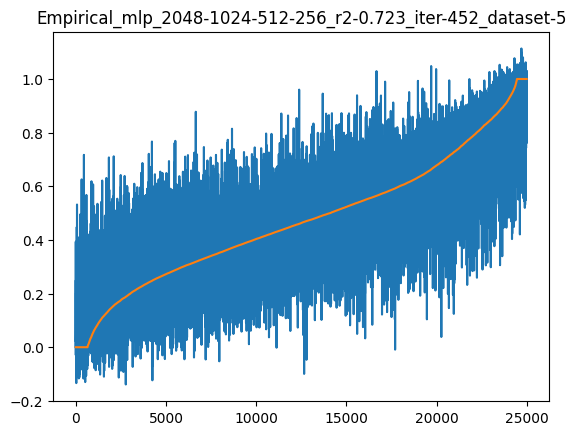

In [233]:
y_pred = regr.predict(X_test)

y_sorted_indices = np.argsort(y_test)

plt.figure()
plt.plot(y_pred[y_sorted_indices])
plt.plot(y_test[y_sorted_indices])
plt.title("Empirical_mlp_2048-1024-512-256_r2-0.723_iter-452_dataset-5")
#plt.savefig("Empirical_mlp_2048-1024-512-256_r2-0.755_iter-452_dataset-3.png", dpi=600)
plt.show()

In [63]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score, f1_score, precision_score, recall_score

X = joblib.load("X_empirical_1.dump")
y = joblib.load("y_empirical_1.dump")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.5)

perf_model = joblib.load("Empirical_mlp_2048-1024-512-256_r2-0.72_iter-557_1.dump")

y_diff = y_pred - y_test
y_conf = [1 if np.abs(sample) < 0.08 else 0 for sample in y_diff]

X_conf_train, X_conf_test, y_conf_train, y_conf_test = train_test_split(X_test, y_conf, random_state=42, test_size=0.2)

conf_model = MLPClassifier(hidden_layer_sizes=(2048, 1048, 512, 256), random_state=42, max_iter=100000, tol=0.0000001, learning_rate_init=0.0001, verbose=True)
conf_model.fit(X_conf_train, y_conf_train)

y_conf_pred = conf_model.predict_proba(X_conf_test)
y_conf_pred = [1 if pred[0] >= 0.9 else 0 for pred in y_conf_pred]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_conf_test, y_conf_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate recall score
recall = recall_score(y_conf_test, y_conf_pred, average='micro' )
print(f"Recall score: {recall}")

# Calculate precision score
precision = precision_score(y_conf_test, y_conf_pred, average='micro' )
print(f"Precision score: {precision}")

# Calculate F1 score
f1 = f1_score(y_conf_test, y_conf_pred, average='micro' )
print(f"F1 score: {f1}")

Iteration 1, loss = 0.68462904
Iteration 2, loss = 0.67856517
Iteration 3, loss = 0.67635003
Iteration 4, loss = 0.67533138
Iteration 5, loss = 0.67289087
Iteration 6, loss = 0.67363405
Iteration 7, loss = 0.67181869
Iteration 8, loss = 0.67043462
Iteration 9, loss = 0.66894425
Iteration 10, loss = 0.66999609
Iteration 11, loss = 0.67011861
Iteration 12, loss = 0.66757604
Iteration 13, loss = 0.66806780
Iteration 14, loss = 0.66883725
Iteration 15, loss = 0.66755522
Iteration 16, loss = 0.66698717
Iteration 17, loss = 0.66681623
Iteration 18, loss = 0.66736241
Iteration 19, loss = 0.66574988
Iteration 20, loss = 0.66736654
Iteration 21, loss = 0.66568105
Iteration 22, loss = 0.66753218
Iteration 23, loss = 0.66516343
Iteration 24, loss = 0.66445529
Iteration 25, loss = 0.66627800
Iteration 26, loss = 0.66505031
Iteration 27, loss = 0.66370867
Iteration 28, loss = 0.66384471
Iteration 29, loss = 0.66371308
Iteration 30, loss = 0.66446927
Iteration 31, loss = 0.66423931
Iteration 32, los

In [ ]:
# Objective function for Optuna
def objective(trial):
    # Suggest number of hidden layers (1-4 layers)
    #n_layers = trial.suggest_int("n_layers", 1, 3)

    # Suggest number of nodes per layer (50-500 nodes)
    #hidden_layer_sizes = tuple(
    #    trial.suggest_int(f"n_units_l{i}", 50, 500) for i in range(n_layers)
    #)

    # Suggest activation function
    #activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])

    # Suggest learning rate initialization
    #learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-2, log=True)

    solver = trial.suggest_categorical("solver", ["adam", "lbfgs", "sgd"])
    learning_rate_method = trial.suggest_categorical("learning_rate", ["adaptive", "constant", "invscaling"])

    #print(f"Starting trial with hidden_layer_size = {hidden_layer_sizes}, activation = {activation}, learning_rate_init = {learning_rate_init}")

    # Create the model
    model = MLPRegressor(
        hidden_layer_sizes=(2048, 1024, 512, 256),
        activation="relu",
        solver=solver,
        learning_rate=learning_rate_method,
        max_iter=5000,
        tol=0.0000001,
        random_state=42,
        learning_rate_init=0.0001,
        verbose=True
    )

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict and calculate F1 score
    #y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)

    #print(f"Finished trial: F1 = {score} with hidden_layer_size = {hidden_layer_sizes}, activation = {activation}, learning_rate_init = {learning_rate_init}")

    return score

# Create a study and optimize
study = optuna.create_study(direction="maximize", storage="sqlite:///optuna_empirical.db", study_name="MLP Regressor (2048, 1024, 512, 256) solver+learning_rate_method optimization", load_if_exists=True)
study.optimize(objective, n_trials=50)

# Print the best hyperparameters and their corresponding F1 score
print("Best trial:")
print(f"Score: {study.best_value}")
print("Best Hyperparameters:", study.best_params)

0.8124947008899008


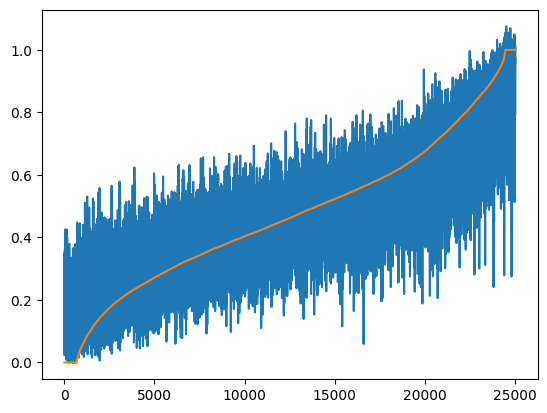

In [31]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import optuna
import joblib
import numpy as np
import matplotlib.pyplot as plt

X = joblib.load("X_empirical_7_30feat.dump")
y = joblib.load("y_empirical_7_30feat.dump")

# quantize by 0.05 steps
#y = np.exp(2 * np.asarray([np.round(2 * sample, 1) / 2 for sample in y]))
#y = np.exp(2 * np.asarray([np.round(2 * sample, 1) / 2 for sample in y]))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.5)

perf_model = XGBRegressor(n_estimators=4500, learning_rate=0.09984, max_depth=30, reg_lambda=1.0, reg_alpha=0.1, objective='reg:quantileerror', quantile_alpha=0.2)
perf_model.fit(X_train, y_train)
print(perf_model.score(X_test, y_test))

y_pred = perf_model.predict(X_test)

y_sorted_indices = np.argsort(y_test)

plt.figure()
plt.plot(y_pred[y_sorted_indices])
plt.plot(y_test[y_sorted_indices])
#plt.title(f"Empirical_xgbregr_nestim-4500_lr-0.09984_md-30_reg_lambda-1.0_reg_alpha-0.1_obj-quantilerr-0.2_r2-{perf_model.score(X_test, y_test)}_dataset-5.png")
#plt.savefig(f"Empirical_xgbregr_nestim-4500_lr-0.09984_md-30_reg_lambda-1.0_reg_alpha-0.1_obj-quantilerr-0.2_r2-{perf_model.score(X_test, y_test)}_dataset-5.png", dpi=600, bbox_inches='tight')
plt.show()

[ True False False False False False False  True False  True False  True
  True  True False  True False]
[ 1  3  8  9  7  4  2  1  6  1 11  1  1  1  5  1 10]
0.7301521353033742


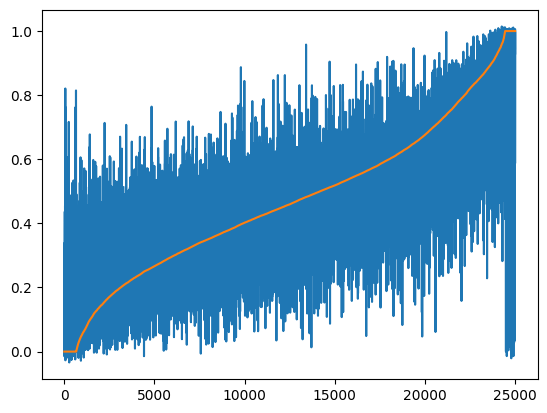

In [196]:
from sklearn.feature_selection import RFE

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.5)

perf_model = XGBRegressor(n_estimators=4500, learning_rate=0.09984, max_depth=30, reg_lambda=1.0, reg_alpha=0.1, objective='reg:squarederror')
rfe = RFE(perf_model, n_features_to_select=7)  # keep n features
rfe.fit(X_train, y_train)
print(rfe.support_)       # boolean mask: True -> selected feature
print(rfe.ranking_)       # ranking of features
rfe.fit(X_train, y_train)
print(rfe.score(X_test, y_test))

y_pred = rfe.predict(X_test)

y_sorted_indices = np.argsort(y_test)

plt.figure()
plt.plot(y_pred[y_sorted_indices])
plt.plot(y_test[y_sorted_indices])
#plt.title(f"Empirical_xgbregr_nestim-4500_lr-0.09984_md-30_reg_lambda-1.0_reg_alpha-0.1_obj-asberr_r2-{perf_model.score(X_test, y_test)}_dataset-3.png")
#plt.savefig(f"Empirical_xgbregr_nestim-4500_lr-0.09984_md-30_reg_lambda-1.0_reg_alpha-0.1_obj-asberr_r2-{perf_model.score(X_test, y_test)}_dataset-3.png", dpi=600, bbox_inches='tight')
plt.show()

In [8]:
# First model prediction confidence model
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, f1_score, precision_score, recall_score

y_diff = y_pred - y_test
y_conf = [1 if np.abs(sample) < 0.05 else 0 for sample in y_diff]

X_conf_train, X_conf_test, y_conf_train, y_conf_test = train_test_split(X_test, y_conf, random_state=42, test_size=0.2)

conf_model = XGBClassifier(n_estimators=4568, learning_rate=0.09984, max_depth=30, objective='binary:logistic')
conf_model.fit(X_conf_train, y_conf_train)

y_conf_pred = conf_model.predict_proba(X_conf_test)
y_conf_pred = [1 if pred[0] >= 0.9 else 0 for pred in y_conf_pred]

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_conf_test, y_conf_pred)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate recall score
recall = recall_score(y_conf_test, y_conf_pred, average='micro' )
print(f"Recall score: {recall}")

# Calculate precision score
precision = precision_score(y_conf_test, y_conf_pred, average='micro' )
print(f"Precision score: {precision}")

# Calculate F1 score
f1 = f1_score(y_conf_test, y_conf_pred, average='micro' )
print(f"F1 score: {f1}")

Mean Squared Error (MSE): 0.8484
Recall score: 0.1516
Precision score: 0.1516
F1 score: 0.1516


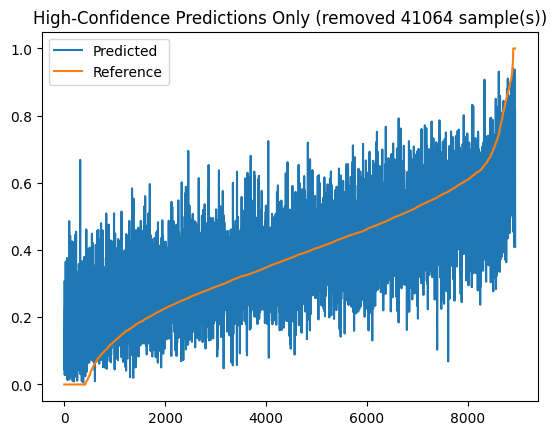

Filtered R² score: 0.6147076995712968


In [231]:
X_final_ref = joblib.load("X_empirical_6_23feat.dump")
y_final_ref = joblib.load("y_empirical_6_23feat.dump")

y_pred_unflt = perf_model.predict(X_final_ref)
y_conf_pred = conf_model.predict_proba(X_final_ref)
y_conf_pred = np.asarray([1 if pred[0] >= 0.98 else 0 for pred in y_conf_pred])

y_pred_flt = y_pred_unflt[y_conf_pred == 1]
y_final_ref_flt = y_final_ref[y_conf_pred == 1]

y_final_sorted_indices = np.argsort(y_final_ref_flt)

plt.figure()
plt.plot(y_pred_flt[y_final_sorted_indices], label='Predicted')
plt.plot(y_final_ref_flt[y_final_sorted_indices], label='Reference')
plt.legend()
plt.title(f"High-Confidence Predictions Only (removed {len(y_pred_unflt) - len(y_pred_flt)} sample(s))")
plt.show()

print("Filtered R² score:", r2_score(y_final_ref_flt, y_pred_flt))

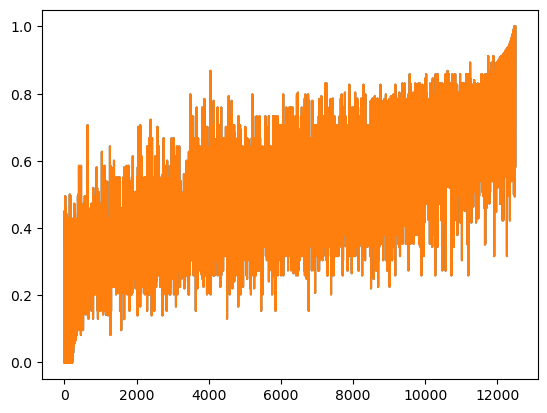

In [3]:
from sklearn.isotonic import IsotonicRegression

iso_reg = IsotonicRegression(out_of_bounds='clip', y_min=0, y_max=1.0, increasing='auto')
y_pred_calibrated = iso_reg.fit_transform(y_pred, y_test)

y_sorted_indices = np.argsort(y_test)

plt.figure()
plt.plot(y_pred_calibrated[y_sorted_indices])
plt.plot(y_pred_calibrated[y_sorted_indices])
plt.show()

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import optuna
import joblib
import numpy as np
import matplotlib.pyplot as plt

X = joblib.load("X_empirical_7_30feat.dump")
y = joblib.load("y_empirical_7_30feat.dump")

# Objective function for Optuna
def objective(trial):
    # Suggest number of hidden layers (1-4 layers)
    #n_layers = trial.suggest_int("n_layers", 1, 3)

    # Suggest number of nodes per layer (50-500 nodes)
    #hidden_layer_sizes = tuple(
    #    trial.suggest_int(f"n_units_l{i}", 50, 500) for i in range(n_layers)
    #)

    # Suggest activation function
    #activation = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])

    # Suggest learning rate initialization
    #learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-2, log=True)

    #solver = trial.suggest_categorical("solver", ["adam", "lbfgs", "sgd"])
    #learning_rate_method = trial.suggest_categorical("learning_rate", ["adaptive", "constant", "invscaling"])

    #print(f"Starting trial with hidden_layer_size = {hidden_layer_sizes}, activation = {activation}, learning_rate_init = {learning_rate_init}")

    n_estimators = trial.suggest_int("n_estimators", 500, 15000)
    learning_rate = trial.suggest_float("learning_rate_init", 0.0001, 0.1, log=True)
    max_depth = trial.suggest_int("max_depth", 4, 30)

    print(f"Trying with n_estimators={n_estimators}, learning_rate={learning_rate}, max_depth={max_depth}")

    # Create the model
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, reg_lambda=1.0, reg_alpha=0.1, objective='reg:quantileerror', quantile_alpha=0.2)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit the model
    model.fit(X_train, y_train)

    # Predict and calculate F1 score
    #y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)

    #print(f"Finished trial: F1 = {score} with hidden_layer_size = {hidden_layer_sizes}, activation = {activation}, learning_rate_init = {learning_rate_init}")
    print(f"Finished trial with score {score}")

    return score

# Create a study and optimize
study = optuna.create_study(direction="maximize", storage="sqlite:///optuna_empirical.db", study_name="XGBRegressor-30feats-quantile", load_if_exists=True)
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and their corresponding F1 score
print("Best trial:")
print(f"Score: {study.best_value}")
print("Best Hyperparameters:", study.best_params)

[I 2025-03-27 16:43:22,231] Using an existing study with name 'XGBRegressor-30feats-quantile' instead of creating a new one.
